# Alaiz Numerical Site Calibration Benchmark
## Introduction
This is the model evaluation notebook of the Alaiz NSC benchmark. A guide for participants can be found [here](https://thewindvaneblog.com/numerical-site-calibration-benchmark-the-alaiz-case-b3767918d812).

The set-up of instruments in Alaiz test site corresponds to *type B* moderate to complex terrain, with relatively low and consistent wind shear and occasional negative shear.   

The site calibration campaign is composed of two short-term periods of a few months where 6 118-m masts are deployed at reference (*MP*) and target (*A*) turbine positions following the spacing requirements of the IEC 61400-12-1 standard. 

* **1st site-calibration campaign (SC1)**: MP6, MP5, MP0, A6, A5, A4  from 2009-11-24 to 2010-06-02
* **2nd site-calibration campaign (SC2)**: MP5, MP3, MP1, A3, A2, A1  from 2010-08-14 to 2010-11-24

To interrelate these periods and assess long-term reference wind conditions we will use MP5 mast. 

* **Long term period (LT)**: MP5   from 2011-04-13 to 2012-10-07

Prototype turbines started operation on 2011-07-21, so we shall exclude the wake-influenced sector [90, 235] from this date.

In [30]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from lib.alaizNSC_functions import *  
from IPython.display import Markdown, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Input Data

### Elevation Map and Instrument Layout
The instrument set-up assumes a hub-height of 118 m and a rotor diameter of 120 m. Hence, we have a top-mounted anemometer at hub-height with additional side-mounted measurements in the lower half of the rotor area down to a distance of 78 m, i.e. minus two thirds of the rotor radius as indicated by the standard. These measurements allow a characterization of the wind shear and an approximation of the rotor equivalent wind speed assumming that the measured wind shear remains the same in the upper half of the rotor.   

While we count with several reference masts from the site calibration campaign, we will asume the conditions of the NSC where only one reference mast is deployed (MP5) and we try predict flow correction factors at the prospect turbine positions. In the Alaiz layout, the separation between the reference and target sites is between 289 m (2.4D) and 1043 m (8.7D). 

In [32]:
# Site
siteID = 'alaizNSC'
HH = 118. # hub-height [m]
D = 120.  # rotor diameter [m]

# Evaluation period
datefrom = datetime.datetime(2009,11,18,0,0,0)    
dateto = datetime.datetime(2012,10,7,0,0,0)  

# Mast positions  VERIFY COORDINATES WITH ELEVATION MAP PROJECTION SYSTEM
masts = pd.read_csv('./inputs/masts.csv') # read {x,y,z} coordinates of target masts
         
# Topography
topo = rio.open('./inputs/DTM_Alaiz_2m.tif') # read nc file in UTM coordinates
box = [612000 , 622000, 4726000, 4736000]    # evaluation area

# Define local coordinate system
ref = 'MP5' # reference site to define origin of coordinate system
ref = masts[masts['Name'] == ref][['easting[m]','northing[m]','elevation[m]']].values[0].tolist()
masts['x[m]'] = masts['easting[m]'] - ref[0]
masts['y[m]'] = masts['northing[m]'] - ref[1]
masts['z[m]'] = masts['elevation[m]'] - ref[2]

masts = masts.set_index('Name')

# Compute distances to MP5 
def dist(x):
    # x = [x,y] cartesian coordinates with respect to MP5
    d = np.sqrt(x[0]**2 + x[1]**2) 
    return d

masts['dist[m]'] = masts[['x[m]','y[m]']].apply(dist, axis = 1) 
masts['dist[D]'] = masts['dist[m]']/D 

#box_xy = [612000 - ref[0], 622000- ref[0], 4726000 - ref[1], 4736000 - ref[1]]    # evaluation area

# Plot elevation map and validation sites
#fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,6))
#basemap = basemap_plot(topo, masts, ref, ax1, coord = 'xy')
#ax1.set_xlim(box_xy[0:2])
#ax1.set_ylim(box_xy[2:4])

masts

,Lon[º],Lat[º],easting[m],northing[m],elevation[m],x[m],y[m],z[m],dist[m],dist[D]
Name,,,,,,,,,,
MP0,-1.556680,42.694389,618225,4727888,1123,91,-91,0,128.693434,1.072445
MP1,-1.571313,42.693546,617028,4727774,1118,-1106,-205,-5,1124.838211,9.373652
MP3,-1.564383,42.694928,617593,4727937,1110,-541,-42,-13,542.627865,4.521899
MP5,-1.557772,42.695223,618134,4727979,1123,0,0,0,0.000000,0.000000
MP6,-1.554737,42.695545,618382,4728019,1115,248,40,-8,251.205095,2.093376
A1,-1.568739,42.691308,617243,4727529,1125,-891,-450,2,998.188860,8.318240
A2,-1.566370,42.691909,617436,4727599,1125,-698,-380,2,794.735176,6.622793
A3,-1.562648,42.692375,617740,4727656,1115,-394,-323,-8,509.475220,4.245627
A4,-1.559086,42.692781,618031,4727706,1121,-103,-273,-2,291.784167,2.431535


## Observations

In [33]:
# Read csv files
files = ['MC1_Ag10_Dc10',
 'MC2_Ag10_Dc10',
 'MC3_Ag10_Fb11',
 'MC4_Nv09_Jn10',
 'MC5_Nv09_Jn10',
 'MC6_Nv09_Jn10',
 'MP5_Nv09_Oc12',
 'MP0_Nv09_Jn10',
 'MP1_Ago10_Ene11',
 'MP6_Nv09_Oc12',
 'MP3_Ago10_Oct12']

masts_obs, levels = read_csv_masts(files)

MC1: from 2010-08-12 13:30:00 to 2010-12-28 23:50:00
MC2: from 2010-08-12 13:10:00 to 2010-12-19 23:50:00
MC3: from 2010-08-14 00:00:00 to 2011-01-11 00:00:00
MC4: from 2009-11-23 04:30:00 to 2010-06-02 10:00:00
MC5: from 2009-11-20 00:00:00 to 2010-06-02 10:10:00
MC6: from 2009-11-20 00:00:00 to 2010-06-02 10:30:00
MP5: from 2009-11-18 16:00:00 to 2012-10-07 23:50:00
MP0: from 2009-11-20 00:00:00 to 2010-06-02 10:20:00
MP1: from 2010-08-12 14:30:00 to 2011-01-02 23:50:00
MP6: from 2009-11-20 00:00:00 to 2012-10-14 23:50:00
MP3: from 2010-08-13 12:20:00 to 2012-10-15 23:50:00


### Quantities of Interest
The following quantities will be evaluated: 

* **Turbulence intensity**: ratio of the wind speed standard deviation to the mean wind speed
$$ TI = \frac{\sigma_{U}}{U} $$

* **Wind shear** accross the lower half of the rotor: power-law exponent $\alpha$ between 78 and 118 m 

$$ U_{high} = U_{low} \left( \frac{z_{high}}{z_{low}} \right) ^{\alpha} $$

* **Flow correction factor** (FCF): wind speed ratio at each position with respect to the reference MP5 hub-height level at 118 m

$$ FCF = \frac{U}{U_{ref}} $$


In [34]:
# Compute quantities of interest
Uref = masts_obs['MP5']['VM118P']
for mast in masts_obs.keys():
    zlevels = levels[mast]['zu']
    
    for z in range(len(zlevels)):
        masts_obs[mast]['TI'+str(zlevels[z])] = masts_obs[mast].iloc[:,levels[mast]['isu'][z]].div(masts_obs[mast].iloc[:,levels[mast]['iu'][z]], axis=0)

    for z in range(len(zlevels)):
        masts_obs[mast]['FCF'+str(zlevels[z])] = masts_obs[mast].iloc[:,levels[mast]['iu'][z]].div(Uref[masts_obs[mast].index], axis = 0)

    masts_obs[mast]['alpha'] = wind_shear(masts_obs[mast].iloc[:,levels[mast]['iu'][3]], 
                                          masts_obs[mast].iloc[:,levels[mast]['iu'][0]],
                                          levels[mast]['zu'][3],levels[mast]['zu'][0]) # based on 118/78 levels

### Evaluation periods

SC1 period: from 2009-11-24 09:00:00 to 2010-06-02 10:00:00, 15695 10-min samples (57.4%)
SC2 period: from 2010-08-14 00:00:00 to 2010-11-24 23:50:00, 13216 10-min samples (89.1%)
LT period: from 2009-11-24 09:00:00 to 2012-10-07 23:50:00, 94280 10-min samples (62.4%)


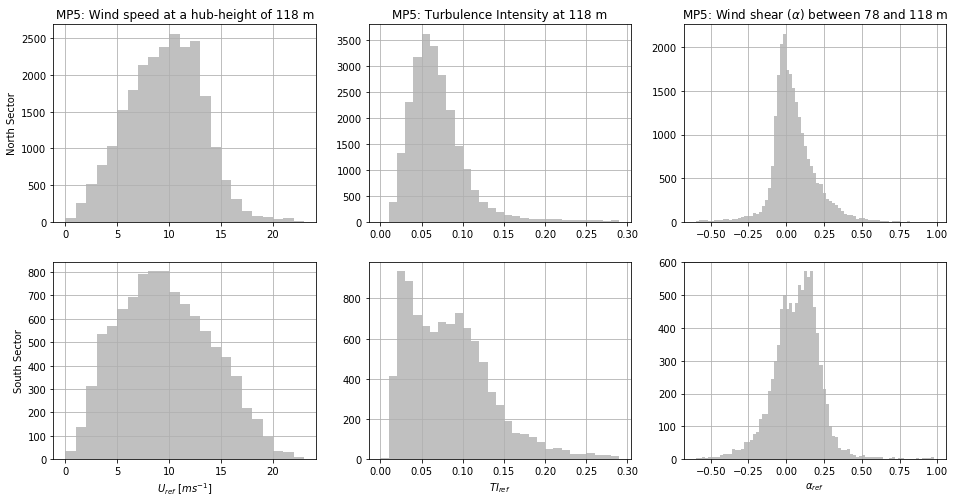

In [35]:
# Define evaluation periods 
SC1 = dict.fromkeys(['MP5','A6','A5','A4'])
SC2 = dict.fromkeys(['MP5','A3','A2','A1'])
LT = dict.fromkeys(['MP5'])

# Datetime indices to the evaluation periods
iSC1 = period_index(SC1, masts_obs, levels,'SC1')
iSC2 = period_index(SC2, masts_obs, levels,'SC2')
iLT = period_index(LT, masts_obs, levels,'LT')

# Exclude wind turbine wake sector in the LT period
WTdatefrom = datetime.datetime(2011,7,21,0,0,0) # Turbines start-up
wake_sector = [90, 235]
WD_ref = masts_obs['MP5']['DVM118']
iwake = WD_ref[((WD_ref >= wake_sector[0]) & (WD_ref <= wake_sector[1]))].index
iwake = iwake[iwake > WTdatefrom] 
iLT = iLT.difference(iwake)

# Plot reference wind conditions at MP5
ref_wind_conditions_hist(iLT,masts_obs)

In [36]:
# Assess shear significance (C.5.1.2)
alpha_ref = masts_obs['MP5'].loc[iLT]['alpha']
shear_significance1 = (alpha_ref > 0.25).sum()/len(alpha_ref)
shear_significance2 = (alpha_ref < 0).sum()/len(alpha_ref)
print('Shear significance: ' + '{:3.1f}'.format(100*shear_significance1) + ' % of shear exponent greater than 0.25')
print('                    ' + '{:3.1f}'.format(100*shear_significance2) + ' % of shear exponent smaller than 0')

Shear significance: 14.9 % of shear exponent greater than 0.25
                    30.8 % of shear exponent smaller than 0


With respecto to IEC 61400-12-1, the wind conditions correspond to a *Type B* terrain with different behaviour between the North and South sectors:

* **North sector**: ridge facing a plain presents a relatively uniform wind speed flow due to the up-hill acceleration leading to rather low turbulence intensities and low wind shear often switching to negative.
* **South sector**: more turbulent due to more rugged terrain, also showing notable wind shear variations around zero

The percentage of samples with a shear exponent greater than 0.25 is less than 25 % but we also see that there is a large percentage of samples with negative shear (35%). Hence, even though shear may be considered not to be a significant factor in site calibration according to the standard (C.5.1.2), we will address shear dependency through varying atmospheric stability in the simulations.   

### Atmospheric Stability
During the site calibration campaign, the met masts count with temperature and humidity sensors at 113, 97 and 81 m. Later on, from 2011-01-18, MP5 mast was equiped with additional sensors at 2 and 40 m. 

Stability is defined based on the inverse of the Froude number following Stull (1988) using the same definition for stable and unstable conditions. 

$$ Fr = \frac{\pi U }{N_{bv}W_T} $$

where $U$ is the wind speed at 118 m, $W_T$ is the characteristic length of the topographic obstacle, set to 1000 m, and $N_{bv}$ is the Brunt-Väisälä frequency: 

$$ N_{bv} = sign \left\{ \frac{\Delta \Theta}{\Delta z} \right\} \sqrt{\frac{g}{\Theta_0} \left| \frac{\Delta \Theta}{\Delta z} \right|} $$

which measures the static stability based on finite differences of the potential temperature gradient at two  levels and is signed to account for stable and unstable conditions. 

Unfortunatelly, the temperature levels during the site calibration campaign are not widely spaced so temperature differences are small and, therefore, subject to high uncertainty. This uncertainty was mitigated later on at MP5 by using the 2-m temperature level. Hence, the histogram of the Froude number based on this level can be used as a benchmark to choose the most appropriate temperature levels during the site calibration campaign.   


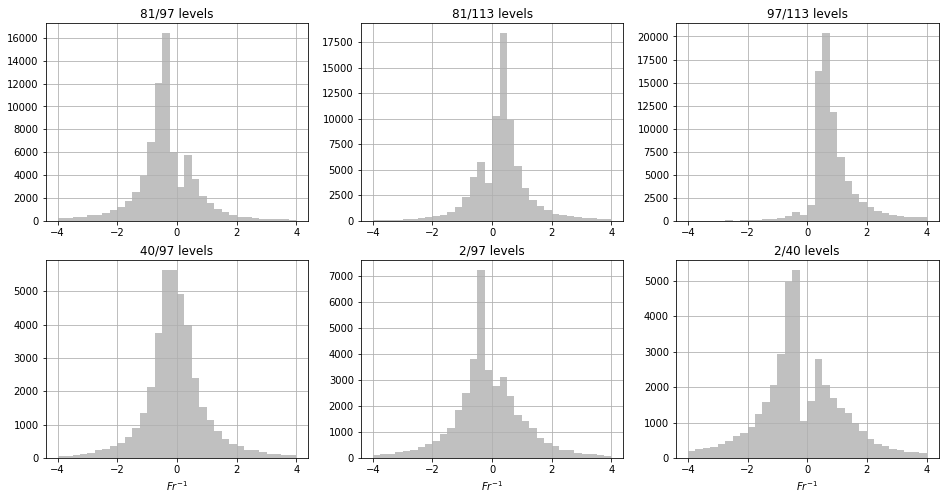

In [37]:
# Potential temperatures at MP5
p0 = masts_obs['MP5'].iloc[:,levels['MP5']['ip']] # reference pressure at 2-m level in hPa
T = masts_obs['MP5'].iloc[:,levels['MP5']['it']] + 273.15 # air temperature in K
Th = potential_temperature(T,p0)
masts_obs['MP5'].iloc[:,levels['MP5']['it']] = Th # replace temperatures by potential temperatures

# Froude number
U = masts_obs['MP5'].iloc[:,levels['MP5']['iu'][0]] # 118 m
Lhill = 1000. 

Fr_inv_81_97 = 1/froude(U,Lhill,levels['MP5']['zt'][2],levels['MP5']['zt'][1],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][2]],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][1]])

Fr_inv_81_113 = 1/froude(U,Lhill,levels['MP5']['zt'][2],levels['MP5']['zt'][0],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][2]],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][0]])

Fr_inv_97_113 = 1/froude(U,Lhill,levels['MP5']['zt'][1],levels['MP5']['zt'][0],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][1]],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][0]])

Fr_inv_40_97 = 1/froude(U,Lhill,levels['MP5']['zt'][3],levels['MP5']['zt'][1],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][3]],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][1]]) # 40 m (starts measuring on 18/01/2011)

Fr_inv_2_97 = 1/froude(U,Lhill,levels['MP5']['zt'][4],levels['MP5']['zt'][1],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][4]],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][1]]) # 2 m (starts measuring on 18/01/2011)

Fr_inv_2_40 = 1/froude(U,Lhill,levels['MP5']['zt'][4],levels['MP5']['zt'][3],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][4]],
                        masts_obs['MP5'].iloc[:,levels['MP5']['it'][3]]) # 2 m (starts measuring on 18/01/2011)

bins = np.arange(-4,4.25,0.25)
fig, ax = plt.subplots(2, 3, figsize = (16,8))
Fr_inv_81_97[iLT].hist(bins = bins, ax = ax[0,0], color= 'silver'); ax[0,0].set_title('81/97 levels')
Fr_inv_81_113[iLT].hist(bins = bins, ax = ax[0,1], color= 'silver'); ax[0,1].set_title('81/113 levels')
Fr_inv_97_113[iLT].hist(bins = bins, ax = ax[0,2], color= 'silver'); ax[0,2].set_title('97/113 levels')
Fr_inv_40_97[iLT].hist(bins = bins, ax = ax[1,0], color= 'silver'); ax[1,0].set_title('40/97 levels'); ax[1,0].set_xlabel(r'$Fr^{-1}$')
Fr_inv_2_97[iLT].hist(bins = bins, ax = ax[1,1], color= 'silver'); ax[1,1].set_title('2/97 levels'); ax[1,1].set_xlabel(r'$Fr^{-1}$')
Fr_inv_2_40[iLT].hist(bins = bins, ax = ax[1,2], color= 'silver'); ax[1,2].set_title('2/40 levels'); ax[1,2].set_xlabel(r'$Fr^{-1}$')

masts_obs['MP5']['Fr_2_40'] = Fr_inv_2_40
masts_obs['MP5']['Fr_81_97'] = Fr_inv_81_97

The 113-m level seems biassed. Let's choose the 81-97 levels to define the Froude number since its histogram is closer to the one depicted at lower levels 2-40 or 2-97. Let's compare the distributions between the two site-calibration periods and the long-term MP5 period.

Text(0.5, 0, '$Fr_{ref}^{-1}$')

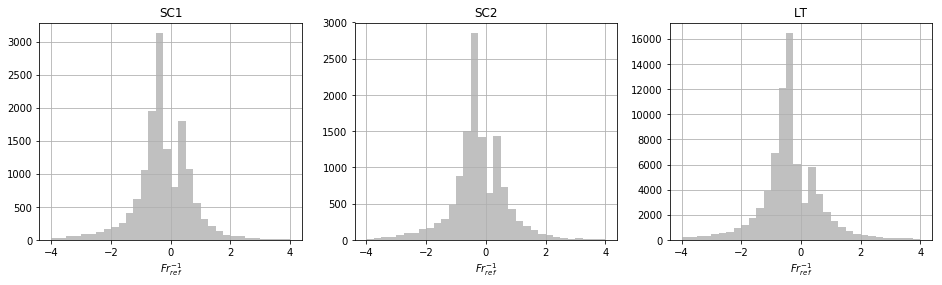

In [38]:
fig, ax = plt.subplots(1, 3, figsize = (16,4))
Fr_inv_81_97[iSC1].hist(bins = bins, ax = ax[0], color= 'silver') 
Fr_inv_81_97[iSC2].hist(bins = bins, ax = ax[1], color= 'silver') 
Fr_inv_81_97[iLT].hist(bins = bins, ax = ax[2], color= 'silver') 
ax[0].set_title('SC1'); ax[0].set_xlabel(r'$Fr_{ref}^{-1}$')
ax[1].set_title('SC2'); ax[1].set_xlabel(r'$Fr_{ref}^{-1}$')
ax[2].set_title('LT'); ax[2].set_xlabel(r'$Fr_{ref}^{-1}$')

## Classification of Wind Conditions (Binning)
We follow the IEC 61400-12-1 *site calibration with shear* procedure (C.5.2) where the flow corrections consist of a matrix of wind direction bins and wind shear bins where a single wind speed ratio correction factor is calculated for each point in the matrix. Following the data acquisiton and rejection criteria (C.4), we limit the wind speed range to 4-16 $m s^{-1}$ and exclude situations with extremely high stability where $|Fr^{-1}| > 0.4$. Stability is used to divide wind shear classes into three categories. Hence, wind conditions will be binned according to the following criteria:  

* Wind direction sectors based on 10º bin size
* Hub-height (118 m) wind speed between 4 and 16 $m s^{-1}$
* Three wind shear classes defined based on the Froude number:
    - Unstable (*u*): $ -4 \leq Fr^{-1} \leq -0.25 $
    - Neutral (*n*):  $ -0.25 \leq Fr^{-1} \leq 0.25 $
    - Stable (*s*):   $ 0.25 \leq Fr^{-1} \leq 4 $

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
u,343.0,60.0,79.0,70.0,20.0,8.0,0.0,0.0,0.0,0.0,...,210.0,155.0,108.0,90.0,65.0,84.0,221.0,648.0,1077.0,1518.0
n,52.0,17.0,18.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,...,83.0,32.0,27.0,14.0,22.0,54.0,97.0,232.0,120.0,145.0
s,132.0,93.0,160.0,67.0,25.0,16.0,8.0,3.0,1.0,2.0,...,105.0,71.0,71.0,53.0,41.0,33.0,58.0,117.0,143.0,235.0


<Figure size 1296x576 with 0 Axes>

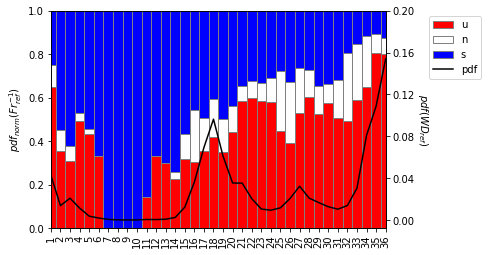

In [39]:
# 36 wind direction sectors
WDbins = np.arange(-5.,360.+5.,10)  # wind direction bins (12 sectors)
WDbins_label = np.array([str(k+1) for k in range(36)])

# 3 stability bins
Frbins = np.array([-4,-0.25,0.25,4])
Frbins_label = np.array(['u','n','s'])

# 1 wind speed bin
Ubins = np.array([4,16])

# Reference wind conditions
U_ref = masts_obs['MP5']['VM118P'] # 118 m level
WD_ref = masts_obs['MP5']['DVM118'] # 118 m level
Fr_ref = masts_obs['MP5']['Fr_81_97'] # 81-97 m level

# Filter validation range
iwc = U_ref[(U_ref >= Ubins[0]) & (U_ref <= Ubins[-1]) & (Fr_ref >= Frbins[0]) & (Fr_ref <= Frbins[-1])].index
iSC1 = iSC1.intersection(iwc)
iSC2 = iSC2.intersection(iwc)
iLT = iLT.intersection(iwc)

# sns.jointplot(WD_ref[iwc], Fr_ref[iwc], kind="kde")

# categorize wind conditions
N_SC1, binmap_SC1 = WD_vs_stab_bins(WD_ref[iSC1],Fr_ref[iSC1],U_ref[iSC1],'count',[WDbins, Frbins],[WDbins_label, Frbins_label],plot = True);
N_SC2, binmap_SC2 = WD_vs_stab_bins(WD_ref[iSC2],Fr_ref[iSC2],U_ref[iSC2],'count',[WDbins, Frbins],[WDbins_label, Frbins_label],plot = False);
N_LT, binmap_LT = WD_vs_stab_bins(WD_ref[iLT],Fr_ref[iLT],U_ref[iLT],'count',[WDbins, Frbins],[WDbins_label, Frbins_label],plot = False);

N_SC1.transpose()
    

### Excluding sectors
Wind direction sectors with less than 144 data points accross all wind shear (stability) bins are excluded (C.5.2).


In [40]:
SC1_exclude = N_SC1[N_SC1.sum(axis = 1) < 144].index
SC2_exclude = N_SC2[N_SC2.sum(axis = 1) < 144].index
exclude = SC1_exclude.union(SC2_exclude)
print('Exclude sectors with less than 144 samples: ' + ','.join([str(x) for x in exclude]))
N_sector = ['1','2','3','35','36']
S_sector = ['16','17','18','19','20']

Exclude sectors with less than 144 samples: 10,11,12,13,14,15,21,22,23,24,25,26,27,29,31,4,5,6,7,8,9


We will concentrate on the North and South prevailing wind directions comprising the following 10º bins:
* **North sector**: sectors 1, 2, 3, 35, 36 (from 335º to 25º)
* **South sector**: sectors 16, 17, 18, 19 and 20 (from 155º to 205º)

### Mean diurnal cycle
Both sectors present a characteristic diurnal cycle with a stronger amplitude in stability and turbulence intensity at the South sector. Stratification is more layered in the South sector with significant differences between the Froude computed near the surface and at the rotor. In the North sector, stability is less dependent with height. Wind shear is higher at night with more frequent stable conditions. During the day, unstable conditions produce higher turbulence intensity lowering the wind shear and becoming predominantly negative in the north sector. 

The shading in the Figure indicates the standard deviation of the data.  

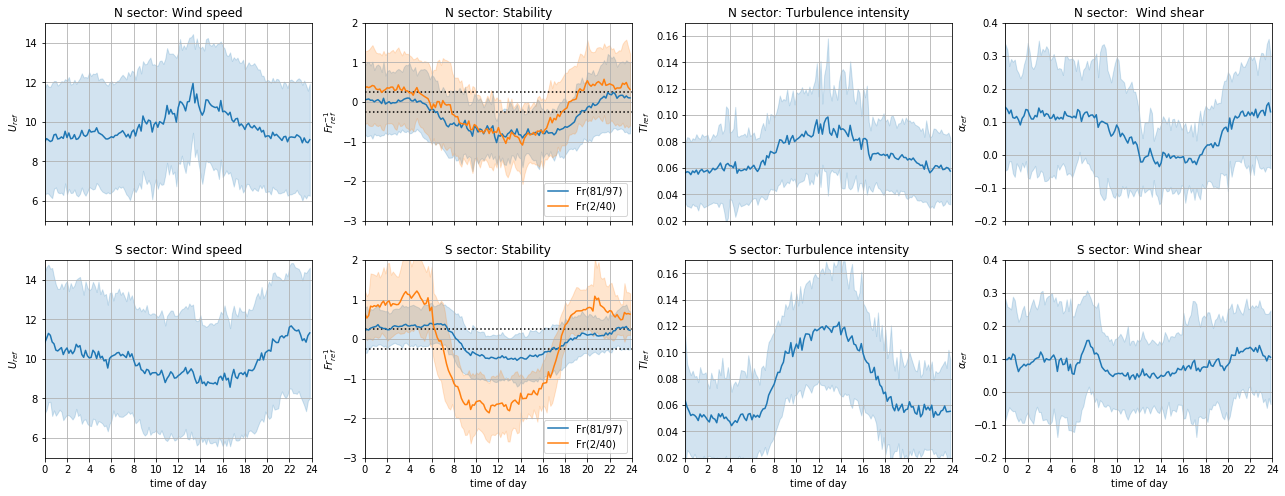

In [41]:
# Wind conditions vs time of the day 
hod = pd.to_datetime(masts_obs['MP5'].index).hour # hour of day
moh = pd.to_datetime(masts_obs['MP5'].index).minute # minute of hour
masts_obs['MP5']['tod'] = hod + moh/60 # time of day

ref_wind_conditions_diurnal_cycle(iLT,masts_obs)

### Correlation between reference and target masts

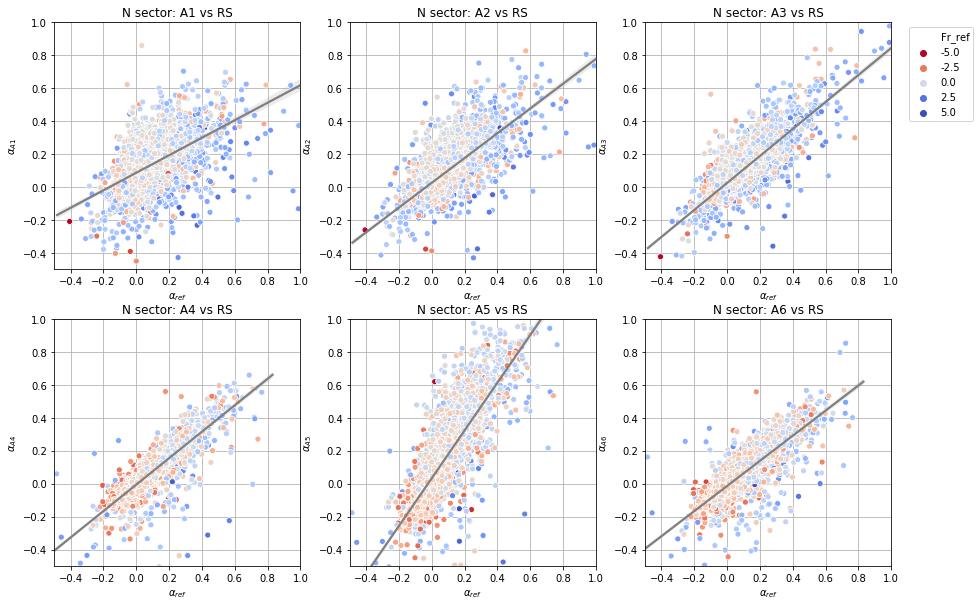

In [42]:
A_vs_RS_scatter('N', 'alpha', 'Fr_ref', masts_obs, iSC1, iSC2)

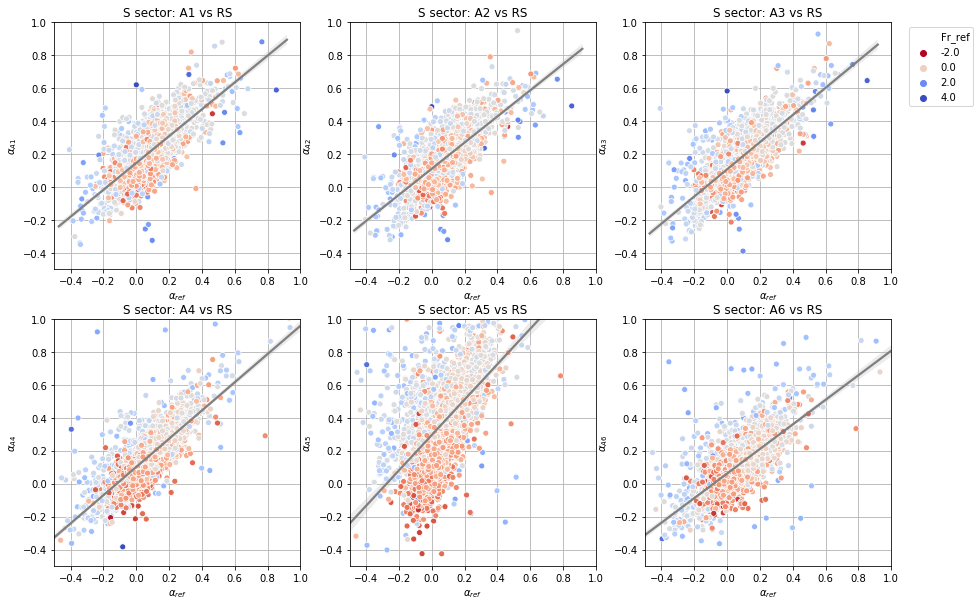

In [43]:
A_vs_RS_scatter('S', 'alpha', 'Fr_ref', masts_obs, iSC1, iSC2)

## Ensemble-averaged profiles   

In [44]:
for mast in SC1.keys():
    SC1[mast] = ensemble_averages(mast, binmap_SC1, masts_obs, WDbins_label, Frbins_label, levels)
for mast in SC2.keys():
    SC2[mast] = ensemble_averages(mast, binmap_SC2, masts_obs, WDbins_label, Frbins_label, levels)
for mast in LT.keys():
    LT[mast] = ensemble_averages(mast, binmap_LT, masts_obs, WDbins_label, Frbins_label, levels)

### Assess long-term representativeness of each bin

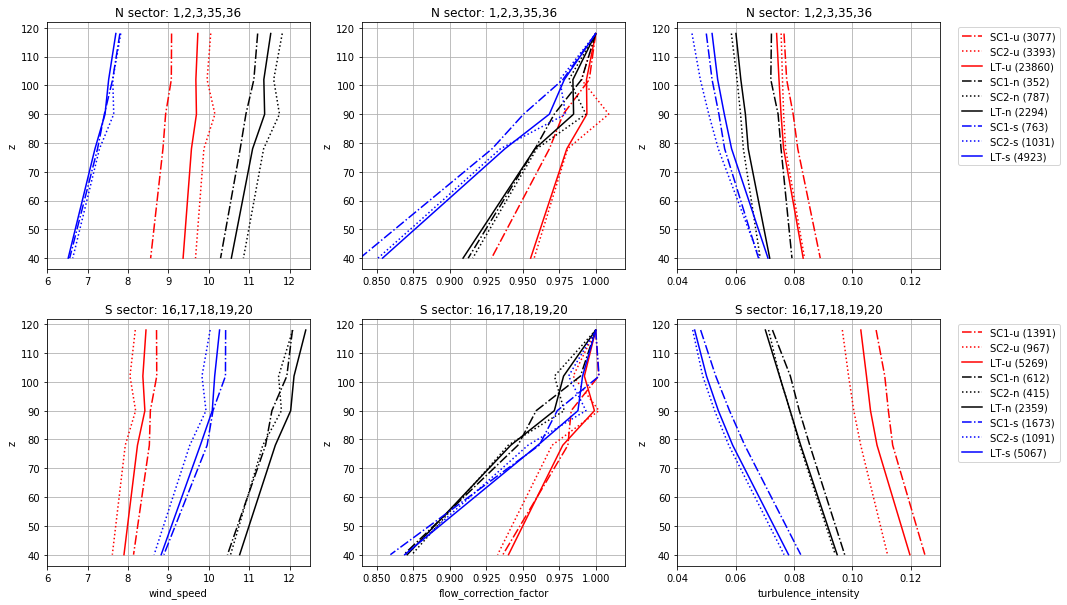

In [45]:
# Compare site calibration (SC) short-term and long-term (LT) mean profiles at MP5
SC_vs_LT_mean_profiles(SC1,SC2,LT,Frbins_label,[N_sector,S_sector])

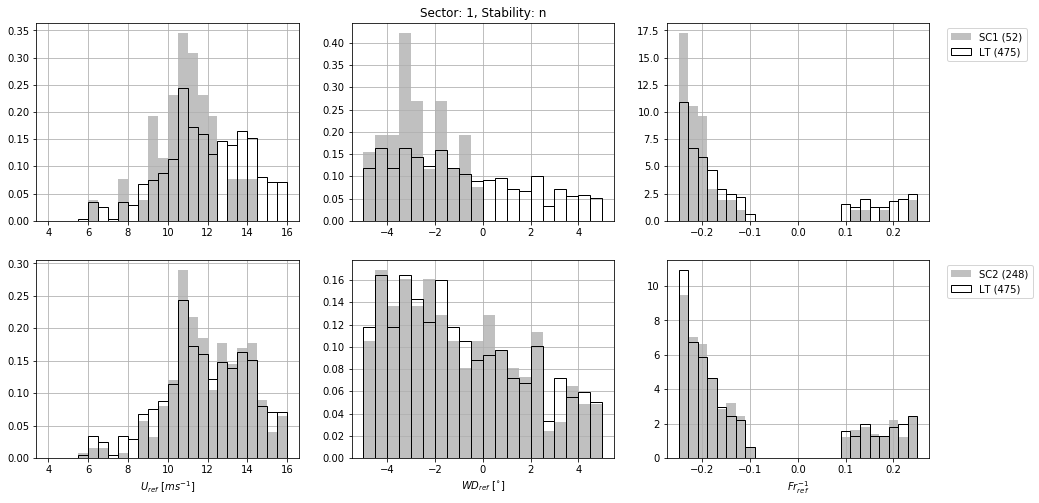

In [46]:
# Plot bin distributions
bin_hist('1', 'n', WDbins_label, Frbins_label, binmap_SC1, binmap_SC2, binmap_LT, U_ref, WD_ref, Fr_ref, Ubins, WDbins, Frbins)

### Mean profiles at target masts

In [47]:
# Mean profiles 
#SC_mean_profiles(SC2,'1',Frbins_label)
#SC_mean_profiles(SC1,'1',Frbins_label)

## Save data

In [48]:
saveresults = True
#if saveresults:
for mast in SC1.keys():
    file_path = './results/' + mast + '_SC1.nc'
    xr = xarray_global_attributes_from_yaml(SC1[mast], './config/Marinet.yaml')
    xr.attrs['comment'] = 'First period of the Site Calibration campaign: Mean and standard deviation of wind speed and turbulence intensity profiles binned by 10º wind direction sectors and 3 stability classes based on Froude number at MP5'
    xr.attrs['time_coverage_start'] = '2009-11-24T00:00:00Z'
    xr.attrs['time_coverage_end'] = '2010-06-02T00:00:00Z'
    xr.to_netcdf(file_path)    
for mast in SC2.keys():
    file_path = './results/' + mast + '_SC2.nc'
    xr = xarray_global_attributes_from_yaml(SC2[mast], './config/Marinet.yaml')
    xr.attrs['comment'] = 'Second period of the Site Calibration campaign: Mean and standard deviation of wind speed and turbulence intensity profiles binned by 10º wind direction sectors and 3 stability classes based on Froude number at MP5'
    xr.attrs['time_coverage_start'] = '2010-08-14T00:00:00Z'
    xr.attrs['time_coverage_end'] = '2010-11-24T00:00:00Z'
    xr.to_netcdf(file_path)    
for mast in LT.keys():
    file_path = './results/' + mast + '_LT.nc'
    xr = xarray_global_attributes_from_yaml(LT[mast], './config/Marinet.yaml')
    xr.attrs['comment'] = 'Long-term period of the Site Calibration campaign: Mean and standard deviation of wind speed and turbulence intensity profiles binned by 10º wind direction sectors and 3 stability classes based on Froude number at MP5'
    xr.attrs['time_coverage_start'] = '2009-11-24T00:00:00Z'
    xr.attrs['time_coverage_end'] = '2012-10-07T00:00:00Z'
    xr.to_netcdf(file_path)    

    
# save MP5 time series to be used as input
MP5out = masts_obs['MP5'].fillna(-9999)
MP5out['SC1'] = 0
MP5out['SC2'] = 0
MP5out['LT'] = 0
MP5out['SC1'].loc[iSC1] = 1
MP5out['SC2'].loc[iSC2] = 1
MP5out['LT'].loc[iLT] = 1
MP5out.to_csv('./results/MP5_input.csv')
